#### Module 1

**Marine Heatwaves**

In this Module we will learn how to use SST data to define and analyse Marine heatwaves (MHWs). We will learn how the selection of different sources and time periods of SST data impacts the definition, and therefore analysis, of MHWs. Specifically, we will:

* Learn the definition of MHWs following Hobday et al.
* Learn to reduce bias when looking at different sources and slices of SST data
* Understand the impact that different SST data has on the defintion of MHWs
* Understand how the choice of SST data impacts the stability of trends and climatology

#### Downloading Data

In [2]:
import xarray as xr
import os
import json
import datetime
import glob
from pydap.client import open_url
from pydap.cas.get_cookies import setup_session
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs 
import cartopy.feature as ccf   
import pandas as pd     
from scipy import stats    
from xmhw.xmhw import threshold, detect, add_doy

In [3]:
def read_credentials_file(authentication_url, credentials_file):
    with open(credentials_file) as json_file:
        credentials = json.load(json_file)
        username, password = credentials[authentication_url]
        return username, password

In [4]:
def copernicus_datastore(authentication_url, dataset, credentials_file):
    '''
    This function authenticates the CMEMS Data Store
    '''
    username, password = read_credentials_file(authentication_url, credentials_file)
    session = setup_session(uri = 'https://cmems-cas.cls.fr/cas/login', username = username,password = password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    data_store = xr.backends.PydapDataStore(open_url(f'{authentication_url}/thredds/dodsC/{dataset}', session = session))
    return data_store

In [14]:
# Create a download directory for our OLCI products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

# Data downloading options
download_cmems_data = False
cmems_credentials_file = os.path.join(os.path.expanduser("~"),'.cmems_opendap')

tags = ["MY", "NRT"]

# Multi-year reprocessing
authentication_url_my = 'https://my.cmems-du.eu'
dataset_my = 'METOFFICE-GLO-SST-L4-REP-OBS-SST'
format_my = 'CLIM_OSTIA_SST_'

# Near real-time
authentication_url_nrt = 'https://nrt.cmems-du.eu'
dataset_nrt = 'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2'
format_nrt = 'OPER_OSTIA_SST_'

# L4 Time series ROI
TS_region = [10, 36, 15, 42] # W, S, E, N

# climatology
start_year = 1982
end_year = 2023

In [15]:
# Time series
if download_cmems_data:
    for authentication_url, dataset, tag in zip([authentication_url_my, authentication_url_nrt], [dataset_my, dataset_nrt], tags):
        data_store = copernicus_datastore(authentication_url, dataset, cmems_credentials_file)
        DS = xr.open_dataset(data_store)
        
        # we call the parameters and we plot the time series:
        for iter_year in range(start_year, end_year):
            try:
                dateStart = datetime.datetime(iter_year, 1, 1).strftime('%Y-%m-%d')
                dateEnd = (datetime.datetime(iter_year+1, 1, 1) - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
                print(f"Getting time series for {dataset}, {iter_year} to {iter_year+1}")
                TS = DS.analysed_sst.sel(lon=slice(TS_region[0], TS_region[2]), lat=slice(TS_region[1], TS_region[3]))\
                                    .sel(time=slice(f"{dateStart}", f"{dateEnd}"))\
                                    .mean(dim=["lon", "lat"])
                if iter_year == end_year or len(TS) >= 365:
                    TS.to_netcdf(os.path.join(download_dir,f"TS_{iter_year}_{tag}.nc"))
            except:
                print(f"No times available for {dataset}")
    
        DS.close()
        data_store.close()

Throughout this project, we'll build up a dictionary `heatwaves` which will keep track of all the data we generate. We'll start by creating sub-dictionaries `heatwaves["MY"]` and `heatwaves["NRT"]` and storing the MY and NRT data in the `"dataset"` attribute of each, respectively.

In [183]:
heatwaves = {}
for tag in tags:
    heatwaves[tag] = {}
    TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))
    DS = xr.open_mfdataset(TS_files)
    heatwaves[tag]["dataset"] = DS

#### Lesson 1

**Defining Marine Heatwaves**

Marine heatwaves are defined by having the properties:
* *Anomalously warm:* a recorded temperature above a high percentile threshold of given climatology data. 
    * Suggested percentile is 90%.
    * Avoids assumptions about the distribution of anomalies, unlike standard deviation.
    * Depends on the choice of climatology.
* *Prolonged:* the temperature must be above the threshold for a certain number of days to be considered as a heatwave.
    * Suggested duration is 5 days. This is backed up with evidence to balance heatwaves in tropical locations (elevated with shorter duration) and in cooler locations (disproportionately diminished with longer duration).
* *Discrete:* a period of cooler days must exist between two periods of elevated temperatures to distinguish them as different heatwaves.
    * Suggested period is 2 days.


#### Lesson 2

**Defining and exploring climatologies**

The `xmhw` Python package includes functionality to calculate climatology from a given SST dataset. Let's first look at our MY data. The `xmhw` package function `threshold` computes the climatology for a given time series `TS`, and stores it as the attribute `threshold(TS).seas`.

In [319]:
clim_start_year = start_year
clim_end_year = end_year

tag = "MY"

heatwaves[tag]["full"] = {}
working_dict = heatwaves[tag]["full"]

working_dict["time_series"] = heatwaves[tag]["dataset"]["analysed_sst"].sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31')) - 273.15
working_dict["start_year"] = working_dict["time_series"][0].time.dt.year.values
working_dict["end_year"] = working_dict["time_series"][-1].time.dt.year.values
working_dict["xmhw_thresh"] = threshold(working_dict["time_series"])

Let's plot our first climatology, computed from the MY dataset over its full range (1982 - 2021).

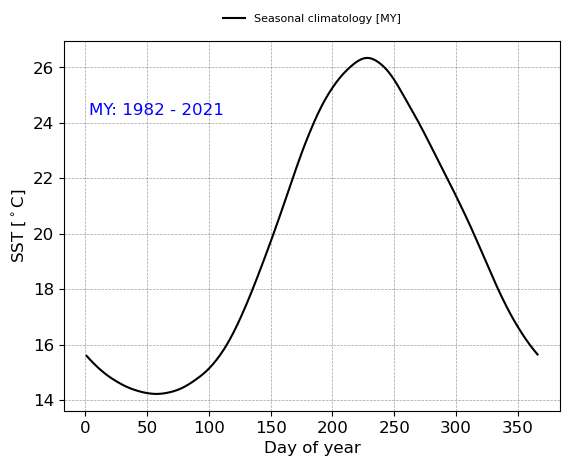

In [320]:
tag = "MY"

plots = []; labels = []; annot = ""

p, = plt.plot(working_dict["xmhw_thresh"].doy,  working_dict["xmhw_thresh"].seas, c = "k")
plots.append(p)
labels.append(f"Seasonal climatology [{tag}]")
annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

By changing the tag to `NRT` we can obtain the full climatology for NRT data. Over the next few lessons we will compare the NRT and MY climatologies generated from different time periods.

#### Lesson 3

**Comparing NRT and MY climatologies**

Let's start by plotting the climatologies produced from the full NRT and MY datasets.

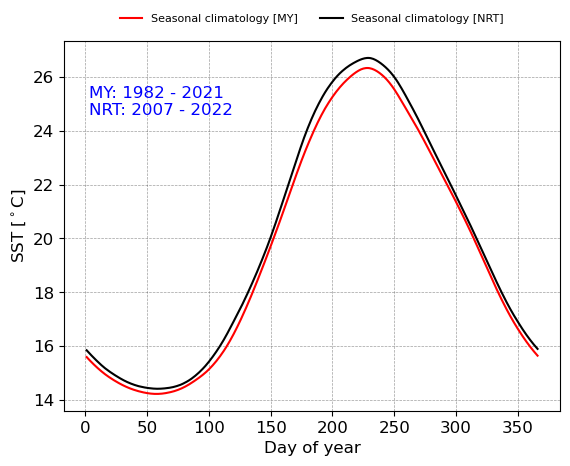

In [321]:
clim_start_year = start_year
clim_end_year = end_year
plots = []; labels = []; annot = ""

for tag, plot_col in zip(["MY", "NRT"], ["r", "k"]):
    working_dict = heatwaves[tag]["full"]
    p, = plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].seas, c = plot_col)
    plots.append(p)
    labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()



We see that NRT > MY. Can we draw any conclusions on this? No! We have made a biased comparison, because we are comparing climatologies generated from two different data sets **and** over two different time periods.

Instead, we should reduce bias by producing plots which differ in only one respect. In the next, we compare MY and NRT climatologies produced from a common period of data, in this case 2007-2021.

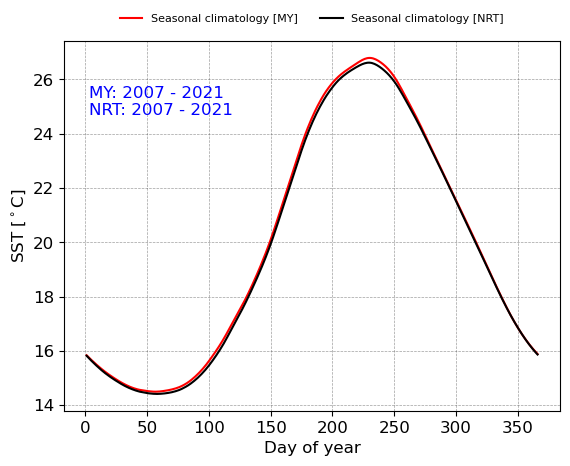

In [323]:
clim_start_year = 2007
clim_end_year = 2021
plots = []; labels = []; annot = ""

for tag, plot_col in zip(["MY", "NRT"], ["r", "k"]):
    heatwaves[tag]["common"] = {}
    working_dict = heatwaves[tag]["common"]
    working_dict["time_series"] = heatwaves[tag]["dataset"]["analysed_sst"].sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31')) - 273.15
    working_dict["start_year"] = working_dict["time_series"][0].time.dt.year.values
    working_dict["end_year"] = working_dict["time_series"][-1].time.dt.year.values
    working_dict["xmhw_thresh"] = threshold(working_dict["time_series"])

    clim = working_dict["xmhw_thresh"]
    p, = plt.plot(clim.doy, clim.seas, c = plot_col)
    plots.append(p)
    labels.append(f"Seasonal climatology [{tag}]")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

We see that over the course of the common period, the MY data reads slightly higher than the NRT data.

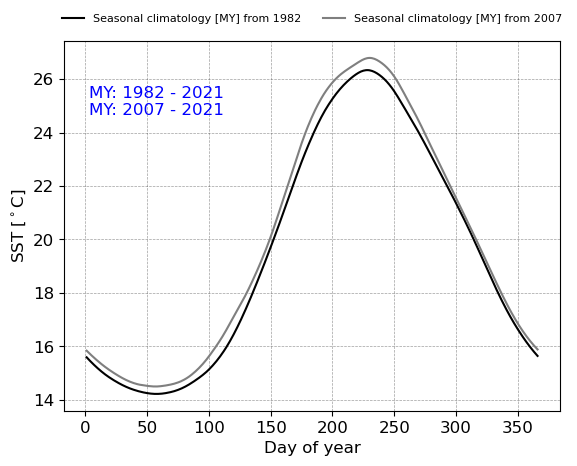

In [325]:
plots = []; labels = []; annot = ""
tag = "MY"

for series, plot_col in zip(["full", "common"], ["k", "tab:gray"]):
    working_dict = heatwaves[tag][series]
    p, = plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].seas, c = plot_col)
    plots.append(p)
    labels.append(f"Seasonal climatology [{tag}] from {working_dict['start_year']}")
    annot += "\n" + f"{tag}: {working_dict['start_year']} - {working_dict['end_year']}"   


plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(plots, labels,
            frameon=False, bbox_to_anchor=(0.5, 1.10), loc='upper center', ncol=2, fontsize=8)
plt.annotate(annot, (0.05, 0.8), xycoords="axes fraction", color='b')
plt.xlabel(r'Day of year')
plt.ylabel(r'SST [$^\circ$C]')
plt.show()

This suggests an upward trend in the MY data over time. We can confirm this with a time series regression.

Trend - R-squared (pvalue): 0.034494 K/year - 0.678777 (0.000000)


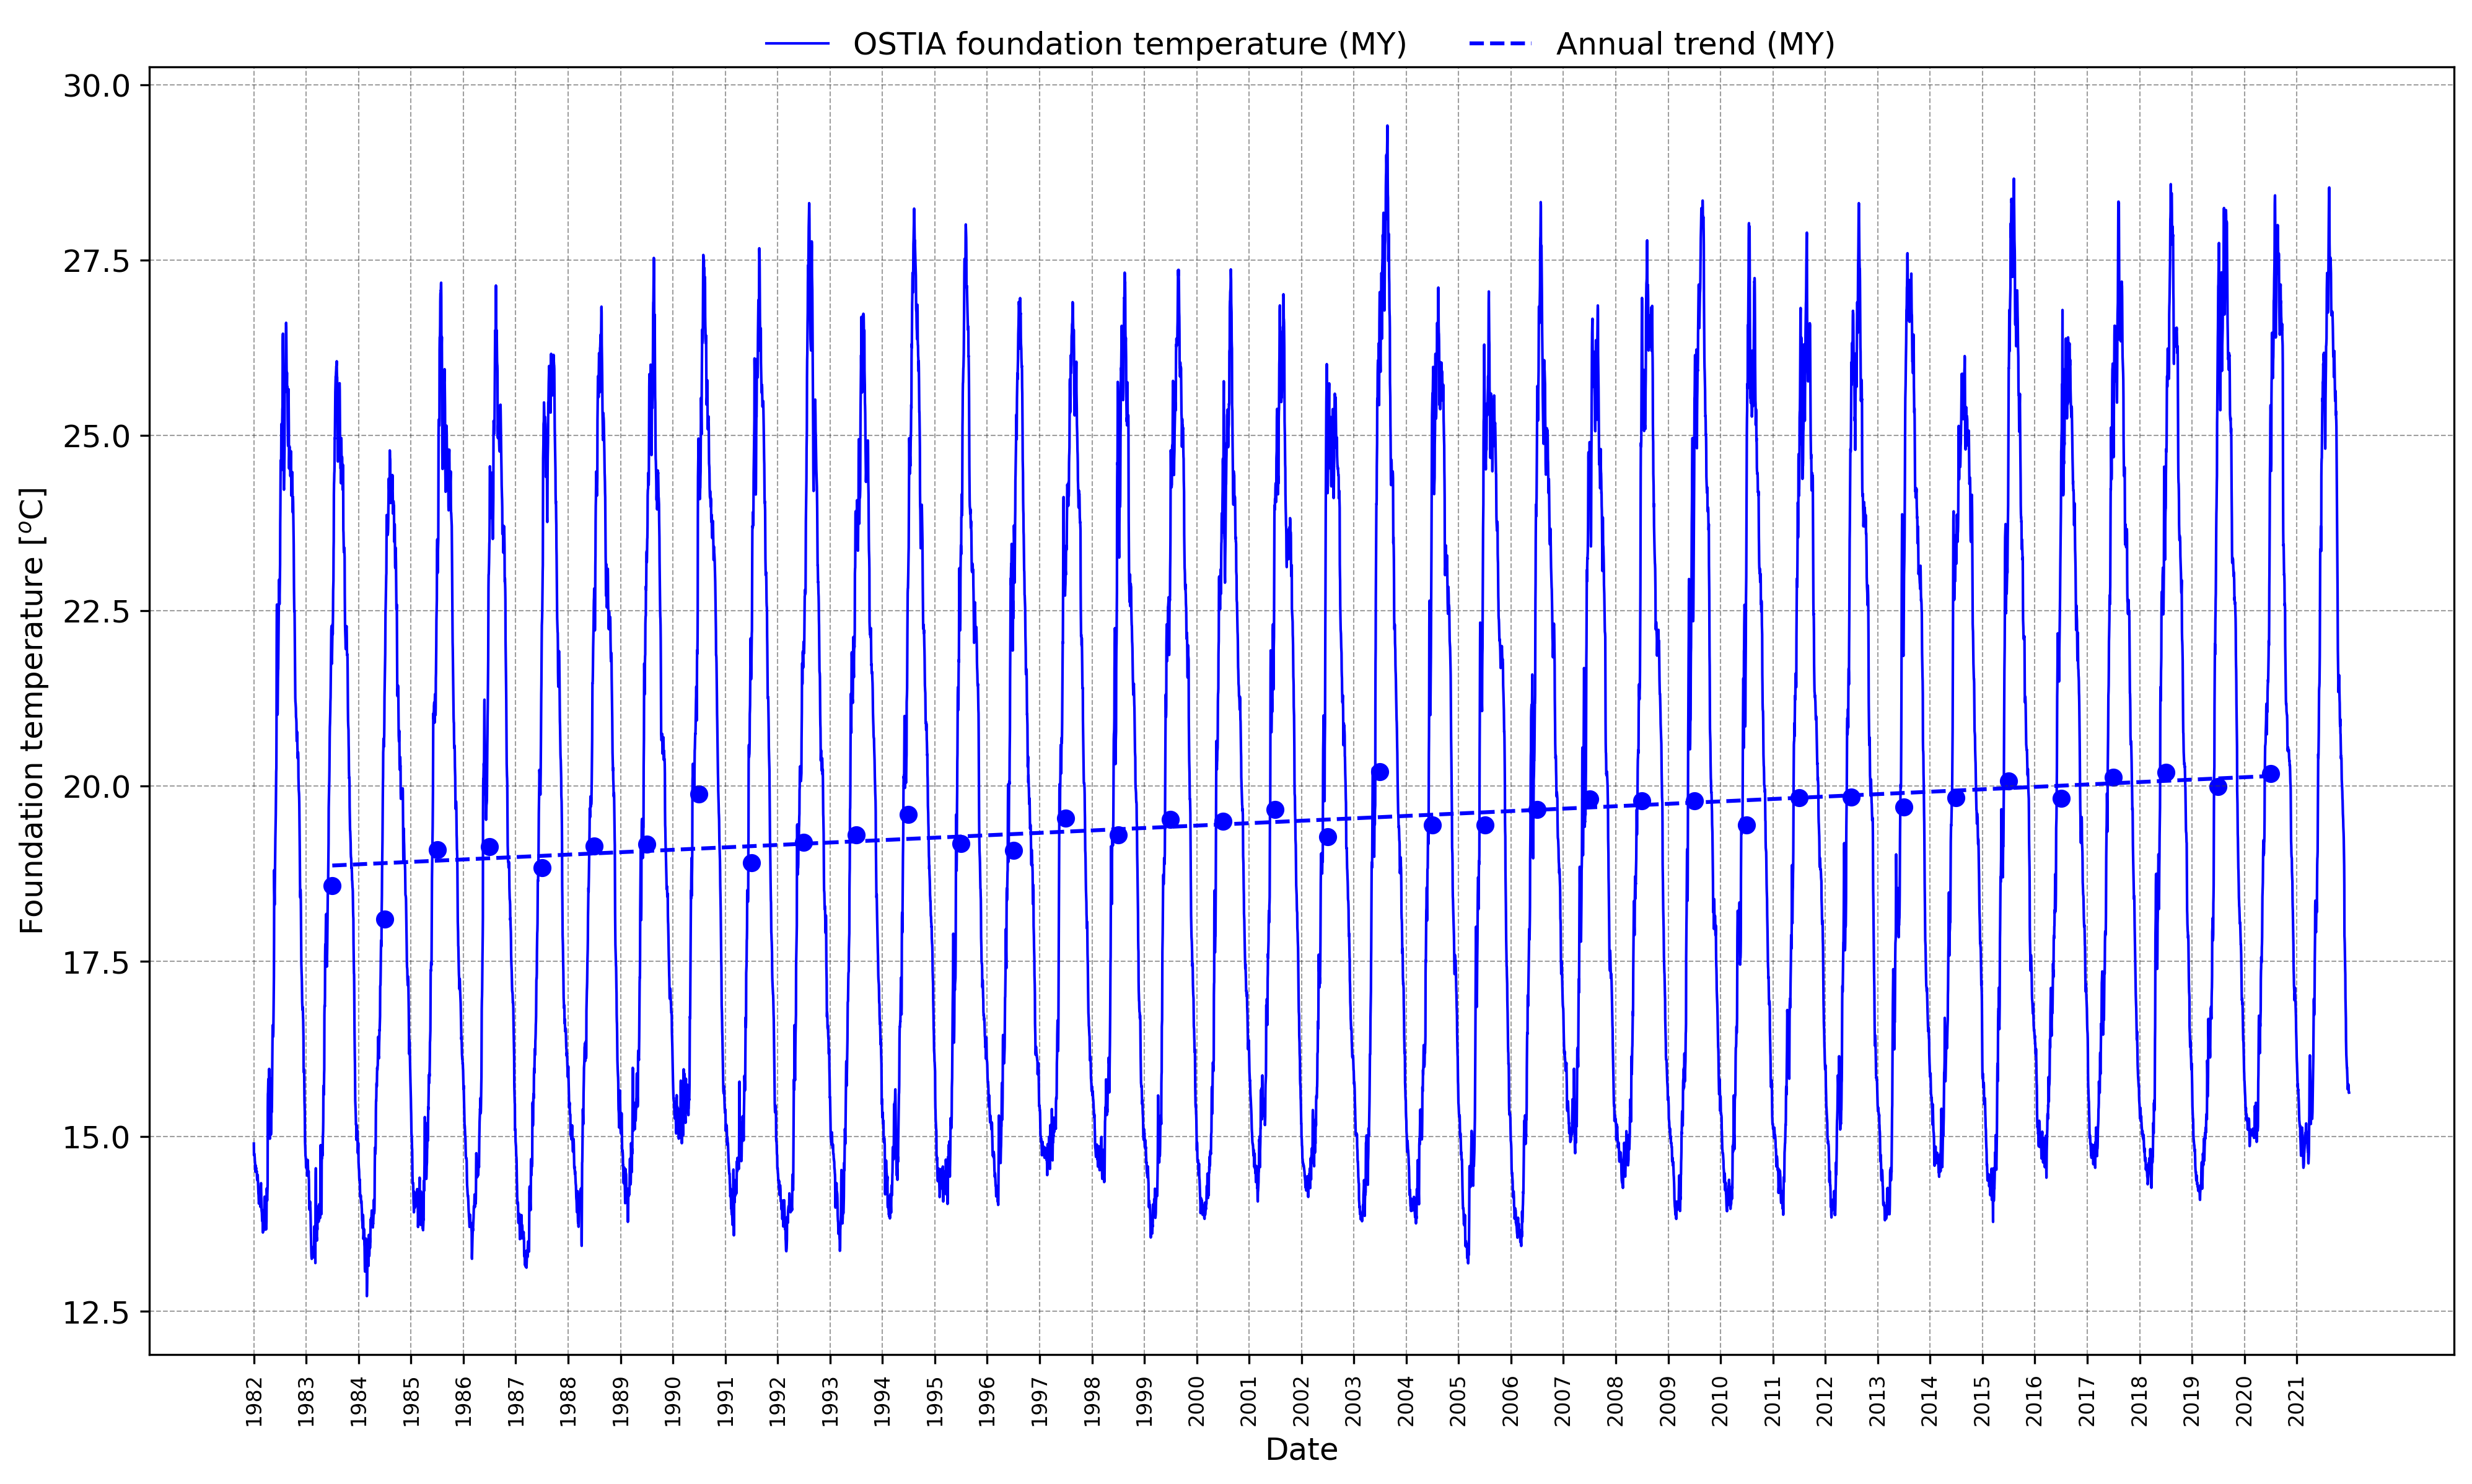

In [ ]:
# setup figure
fig = plt.figure(figsize=(16, 9), dpi=300)
plt.rc('font', size=12)

plots = [] ; labels = []; xticks = []; xtick_labels= []

clim_start_year = start_year
clim_end_year = end_year

for tag, plot_colour in zip(["MY"], ["b"]):
    TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))
    
    DS = xr.open_mfdataset(TS_files).sel(time=slice(f'{clim_start_year}-01-01', f'{clim_end_year}-12-31'))
    DS["timeordinal"]=(['time'],  [pd.to_datetime(x).toordinal() for x in DS.time.values])

    p1, = plt.plot(DS.timeordinal, DS.analysed_sst - 273.15, linewidth=1, c=plot_colour)
    plots.append(p1)
    labels.append(f"OSTIA foundation temperature ({tag})")

    # calculate trend
    annual = DS.groupby('time.year').mean('time')
    res = stats.linregress(annual.timeordinal[1:-1], annual.analysed_sst[1:-1] - 273.15)
    plt.scatter(annual.timeordinal[1:-1], annual.analysed_sst[1:-1] - 273.15, c=plot_colour)
    p2, = plt.plot(annual.timeordinal[1:-1], res.intercept + res.slope*annual.timeordinal[1:-1],
                   color=plot_colour, linestyle="--", label='fitted line')
    plots.append(p2)
    labels.append(f"Annual trend ({tag})")
    xticks.append([datetime.datetime(ii.data, 1, 1).toordinal() for ii in  annual.year])
    xtick_labels.append(annual.year)
    print(f"Trend - R-squared (pvalue): {res.slope*365:.6f} K/year - {res.rvalue**2:.6f} ({res.pvalue**2:.6f})")

plt.xticks(np.array([item for sublist in xticks for item in sublist]),
           labels=np.array([item for sublist in xtick_labels for item in sublist]),
           rotation=90, fontsize=8)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
legend = plt.legend(plots, labels, frameon=False, bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=4)
plt.xlabel("Date")
plt.ylabel("Foundation temperature [$^{o}$C]")

plt.savefig("OSTIA_timeseries.png", bbox_inches='tight')

#### Lesson 3

**Detecting MHWs**

* Learn the process of plotting the MHW detection threshold for a given climatology.
* Learn to produce plots demonstrating the detection of MHWs.
* Appreciate how adjusting the detection threshold can change what MHWs are detected.

#### Lesson 4

**Analysing MHWs for different data sources**

* Understand how different data sources detect different MHWs.
* Derive an example of a MHW which is detected from one dataset but not another.

#### Lesson 4

**Analysing MHWs for different climatologies produced from the same data source**

* Appreciate that different climatologies produced from the same data source (different time periods) affects the detection of MHWs.
* Derive an example of a year where the MHWs detected are different based on using current climatology vs. climatology up to that year.

#### Lesson 5

**Stability**

Work in progress: calculation of successive 15 year trend gradients of MY data.

1982 -- 1997: Trend - R-squared (pvalue): 0.056956 K/year - 0.321520 (0.001188)
1983 -- 1998: Trend - R-squared (pvalue): 0.053401 K/year - 0.297050 (0.001923)
1984 -- 1999: Trend - R-squared (pvalue): 0.022796 K/year - 0.119315 (0.051268)
1985 -- 2000: Trend - R-squared (pvalue): 0.025940 K/year - 0.147835 (0.030505)
1986 -- 2001: Trend - R-squared (pvalue): 0.027988 K/year - 0.168196 (0.021104)
1987 -- 2002: Trend - R-squared (pvalue): 0.023288 K/year - 0.132301 (0.040443)
1988 -- 2003: Trend - R-squared (pvalue): 0.013967 K/year - 0.049745 (0.196613)
1989 -- 2004: Trend - R-squared (pvalue): 0.031500 K/year - 0.152426 (0.028072)
1990 -- 2005: Trend - R-squared (pvalue): 0.046200 K/year - 0.382649 (0.000337)
1991 -- 2006: Trend - R-squared (pvalue): 0.030690 K/year - 0.214314 (0.009124)
1992 -- 2007: Trend - R-squared (pvalue): 0.028612 K/year - 0.192406 (0.013608)
1993 -- 2008: Trend - R-squared (pvalue): 0.032188 K/year - 0.229400 (0.006913)
1994 -- 2009: Trend - R-squared (pvalue)

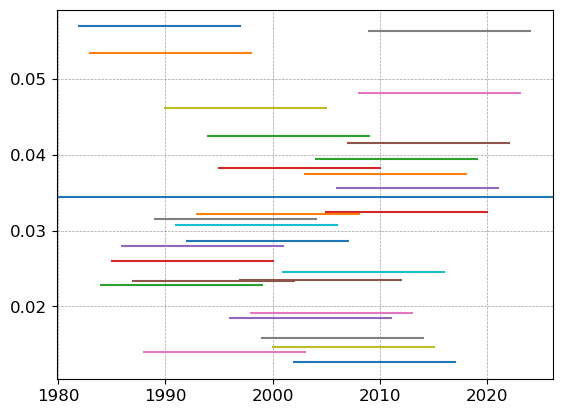

In [312]:
tag = "MY"
gap = 15
TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))
for clim_start_year in range(1982, 2010):
    DS = xr.open_mfdataset(TS_files).sel(time=slice(f'{clim_start_year}-01-01', f'{clim_start_year + gap}-12-31'))
    DS["timeordinal"]=(['time'],  [pd.to_datetime(x).toordinal() for x in DS.time.values])
    annual = DS.groupby('time.year').mean('time')
    res = stats.linregress(annual.timeordinal[1:-1], annual.analysed_sst[1:-1] - 273.15)
    print(f"{clim_start_year} -- {clim_start_year + gap}:", f"Trend - R-squared (pvalue): {res.slope*365:.6f} K/year - {res.rvalue**2:.6f} ({res.pvalue**2:.6f})")
    plt.plot([clim_start_year, clim_start_year + gap], [res.slope*365, res.slope*365])
    
plt.axhline(0.034494)
plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()



### Materials in progress

These will fill parts of the course above.

In [162]:
tag = "MY"

TS_files = glob.glob(os.path.join(download_dir,f"TS_*_{tag}.nc"))

DS = xr.open_mfdataset(TS_files)

DS["DoY"]=(["time"], np.array(DS.time.dt.dayofyear)-1)

clims = {}
mhws = {}
ssts = {}

sst = DS.analysed_sst.sel(time=slice('2012-01-01', '2012-12-31')) - 273.15

clims['ref'] = threshold(DS.analysed_sst.sel(time=slice(f'{start_year}-01-01', f'2022-12-31')) - 273.15)

for year in range(2000,2013):
    clims[f'{year}'] = threshold(DS.analysed_sst.sel(time=slice(f'{start_year}-01-01', f'{year}-12-31')) - 273.15)
    ssts[f'{year}'] = DS.analysed_sst.sel(time=slice(f'{year}-01-01', f'{year}-12-31')) - 273.15
    mhws[f'{year}'] = [detect(ssts[f'{year}'], clims[f'{year}'].thresh, clims[f'{year}'].seas),
                       detect(ssts[f'{year}'], clims['ref'].thresh, clims['ref'].seas)]




In [133]:
for year in range(2000,2013):
    mhw = mhws[f'{year}']
    print({f'*****{year}*****'})
    for i in range(2):
        print(list(zip(mhw[i].index_start.values, mhw[i].duration.values, mhw[i].intensity_cumulative.values)))


{'*****2000*****'}
[(134.0, 34.0, 70.75235), (172.0, 5.0, 8.002514), (180.0, 5.0, 7.397459), (235.0, 9.0, 12.0599575)]
[(136.0, 5.0, 9.736166), (152.0, 9.0, 17.625576)]
{'*****2001*****'}
[(81.0, 8.0, 9.085601), (284.0, 32.0, 46.379646)]
[(81.0, 7.0, 6.791195), (289.0, 22.0, 29.688221)]
{'*****2002*****'}
[(168.0, 14.0, 37.226395)]
[(170.0, 8.0, 19.920965)]
{'*****2003*****'}
[(120.0, 19.0, 39.171036), (151.0, 61.0, 187.2549), (216.0, 36.0, 83.80851)]
[(122.0, 14.0, 25.746132), (152.0, 60.0, 156.9188), (217.0, 34.0, 71.635544)]
{'*****2004*****'}
[(179.0, 11.0, 23.075659), (294.0, 19.0, 24.896952)]
[(304.0, 8.0, 9.657282)]
{'*****2005*****'}
[(119.0, 5.0, 7.6631336), (148.0, 5.0, 11.199682), (173.0, 10.0, 26.72588), (304.0, 19.0, 26.263676)]
[(173.0, 8.0, 18.830318), (305.0, 18.0, 22.562138)]
{'*****2006*****'}
[(136.0, 9.0, 19.419579), (181.0, 5.0, 9.589373), (193.0, 22.0, 46.280727), (327.0, 38.0, 47.65258)]
[(137.0, 7.0, 14.16946), (202.0, 11.0, 22.35497), (330.0, 18.0, 21.436052), 

We can get more **and** fewer heatwaves by adjusting climatology.

In [146]:
year = 2007

x_values = np.union1d(mhws[f'{year}'][0]['index_start'].values, mhws[f'{year}'][0]['index_end'].values)
y_values = clims[f'{year}'].thresh.sel(doy = x_values).values

print(x_values, y_values)

[  1.  78.  95. 121. 126. 134. 141. 145.] [16.13693641 15.13226614 15.50302665 17.40981908 18.09504749 19.2054153
 20.11732089 20.64091295]


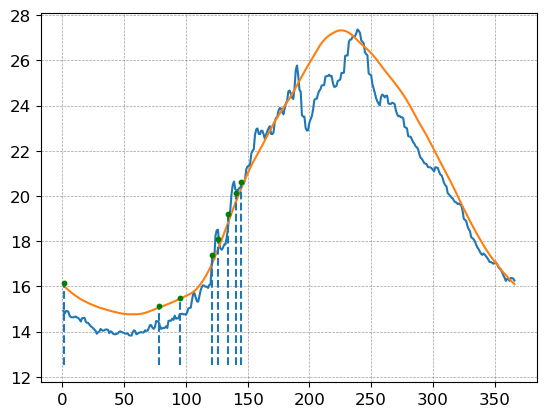

In [150]:
year = 2000



plt.plot(clims[f'{year}'].doy, ssts[f'{year}'])
#plt.plot(clims['ref'].doy, clims['ref'].thresh)
plt.plot(clims[f'{year}'].doy, clims[f'{year}'].thresh)
plt.vlines(x_values, 12.5, y_values, linestyle="dashed")
plt.scatter(x_values, y_values, zorder=2, c='g', s=10)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

# TODO: Plot the heatwave starts, ends with dotted lines. fill between?

[138. 149. 164. 169. 227. 250.]


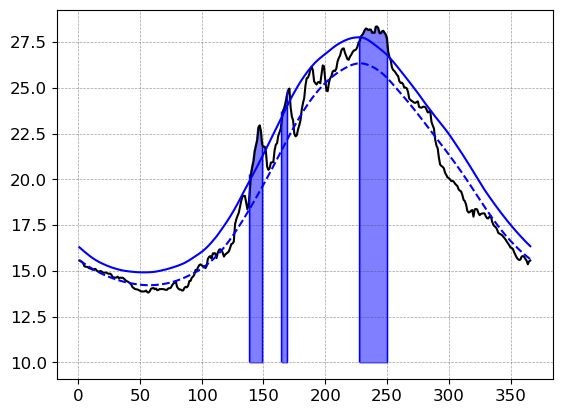

In [ ]:
tag = "MY"

working_dict = heatwaves[tag]["full_series"]

year = 2009

working_dict[f'{year}'] = {}
working_dict[f'{year}']['time_series'] = working_dict["time_series"].sel(time = slice(f'{year}-01-01', f'{year}-12-31'))
working_dict[f'{year}']['mhws'] = detect(working_dict[f'{year}']["time_series"], working_dict["xmhw_thresh"].thresh, working_dict["xmhw_thresh"].seas)
#np.where(working_dict['2003']['time_series'].time == working_dict['2003']['mhws'].time_start[2].values)
x_values = np.union1d(working_dict[f'{year}']['mhws'].index_start.values, working_dict[f'{year}']['mhws'].index_end.values)

print(x_values)

y_values = [working_dict[f'{year}']['time_series'][int(x)] for x in x_values]


plt.plot(working_dict[f'{year}']['time_series'].doy, working_dict[f'{year}']['time_series'], c = "k")
plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].thresh, c = "b")
plt.plot(working_dict["xmhw_thresh"].doy, working_dict["xmhw_thresh"].seas, c = "b", linestyle = "--")
#plt.scatter(x_values, y_values, s = 10, c = "r", zorder = 2)
plt.vlines(x_values, 10, y_values, color = 'b', linewidth = 1, zorder = 2)
for t1, t2 in zip(*[iter(x_values)]*2):
    plt.fill_between(working_dict['xmhw_thresh'].doy[int(t1):int(t2)], working_dict[f'{year}']['time_series'][int(t1):int(t2)], 10, color = 'b', alpha = 0.5)
plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()